In [15]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [16]:
import os
import re
import matplotlib
import matplotlib.pyplot as plt
import glob
import math
import numpy as np
import pandas as pd
from bisect import *
from decimal import Decimal
#from scipy.optimize import curve_fit
#import scipy.special as sps

In [17]:
dir = '/Users/innocent/cernbox/HepSpec/fragData/'
#file = dir+'dumpMemMonFIXED.log'
file = dir+'dumpMemMon_benchAllA.log'
#file = dir+'dumpMemMon_benchNoTHP.log'
#file = dir+'dumpMemMonJE3.log'
#file = dir+'dumpMemMonBNoTHP.log'
#file = dir+'dumpMemMonMultiA2.log'
#file = dir+'dumpMemMon_longAMD3.log'
lines = open(file).read().split('END\n')

In [18]:
def oneVal(elems,tag) :
  for elem in elems:
    if elem.find(tag) != -1 : return re.findall("\d+",elem)[0]
  return '0'

def buddy(elems,tag) :
  for elem in elems:
    if elem.find(tag) != -1 : return re.findall("\d+",elem.split(',')[1])
  return ['0','0','0','0','0','0','0','0','0','0','0']

def times(elems,tag) :
  uTime = 0
  sTime = 0
  for elem in elems:
    if elem.find(tag) != -1 :
      a = elem
      if elem.find(')') !=-1 : a = elem.split(')')[1]
      times =  re.findall("\d+",a)
      uTime += int(times[0])
      if elem.find(')') ==-1 : uTime += int(times[1]) 
      sIndex = 1
      if elem.find(')') ==-1 : sIndex = 2
      sTime += int(times[sIndex])
  return [uTime,sTime]

def parseOne(elems) :
  ret = []
  date = elems[0]
  time = elems[1]
  ret.append(time)
  power = oneVal(elems,'power')
  ret.append(power)
  heap = oneVal(elems,'AnonPages')
  ret.append(heap)
  huge = oneVal(elems,'AnonHugePages')
  ret.append(huge)
  buddy0 = buddy(elems,'Node 0')
  ret+=buddy0
  buddy1 = buddy(elems,'Node 1')
  ret+=buddy1
  cpu = times(elems,'cpu')
  ret+=cpu
  job = times(elems,'cms')
  ret+=job
  return ret

In [19]:
data = []
for line in lines :
  elems = line.split('\n')
  if len(elems) < 3 : continue
  row = [int(x) for x in parseOne(elems)]
  data.append(row)

In [20]:
columns = ['time','power','heap','hugePages']
columns += ['N0_'+str(x) for x in list(range(0, 11))]
columns += ['N1_'+str(x) for x in list(range(0, 11))]
columns +=['totUtime','totStime','jobUtime','jobStime']
df = pd.DataFrame(data,columns=columns)
clus=df
print(clus.index)
print(clus.columns)
print(clus.size)
print(clus.describe())
print(clus.head())
print(clus.tail())

RangeIndex(start=0, stop=731, step=1)
Index(['time', 'power', 'heap', 'hugePages', 'N0_0', 'N0_1', 'N0_2', 'N0_3',
       'N0_4', 'N0_5', 'N0_6', 'N0_7', 'N0_8', 'N0_9', 'N0_10', 'N1_0', 'N1_1',
       'N1_2', 'N1_3', 'N1_4', 'N1_5', 'N1_6', 'N1_7', 'N1_8', 'N1_9', 'N1_10',
       'totUtime', 'totStime', 'jobUtime', 'jobStime'],
      dtype='object')
21930
               time       power          heap     hugePages           N0_0  \
count  7.310000e+02  731.000000  7.310000e+02  7.310000e+02     731.000000   
mean   1.674318e+09  232.474692  5.202094e+07  1.887663e+07   15743.644323   
std    2.262326e+03   33.331385  2.796895e+07  1.496828e+07   61470.696844   
min    1.674314e+09    0.000000  6.027440e+05  3.092480e+05       0.000000   
25%    1.674316e+09  239.000000  3.466020e+07  9.284608e+06      69.000000   
50%    1.674318e+09  244.000000  4.716748e+07  1.142374e+07     427.000000   
75%    1.674320e+09  247.000000  7.699333e+07  3.034214e+07    3583.500000   
max    1.674322e+

In [21]:
df['jobUtime'] =  df['jobUtime'] - df['jobUtime'].shift(1, fill_value=0)
df['jobStime'] =  df['jobStime'] - df['jobStime'].shift(1, fill_value=0)

df['totUtime'] =  df['totUtime'] - df['totUtime'].shift(1, fill_value=0)
df['totUtime'][0] = 0
df['totStime'] =  df['totStime'] - df['totStime'].shift(1, fill_value=0)
df['totStime'][0] = 0
df[df<0] = 0
df[df<1] = 0.5

#df = df.head(50)
#ymax = 155
ymax = 750 #900

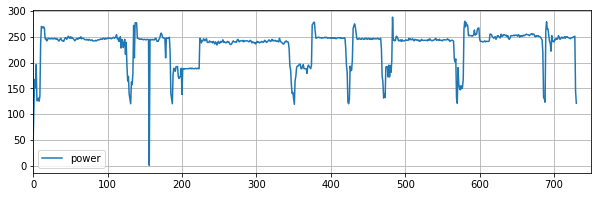

246.3806343906511

In [22]:
fig, axs = plt.subplots(figsize=(10, 3))
df['power'].plot()
axs.set_xlim(0.,ymax)
axs.legend()
axs.grid()
plt.show()
ave = df['power'].mean()
df[df['power']>0.9*ave]['power'].mean()

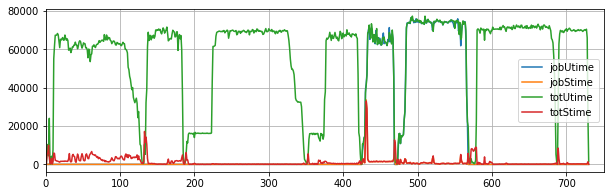

In [23]:
fig, axs = plt.subplots(figsize=(10, 3))
df['jobUtime'].plot()
df['jobStime'].plot()
df['totUtime'].plot()
df['totStime'].plot()
#print(df.head())
axs.set_xlim(0.,ymax)
axs.legend()
axs.grid()
plt.show()

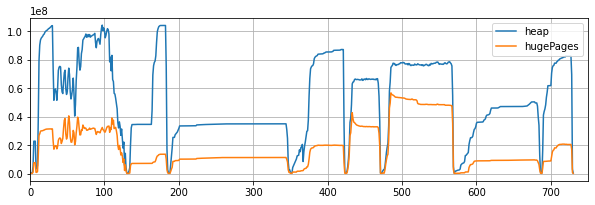

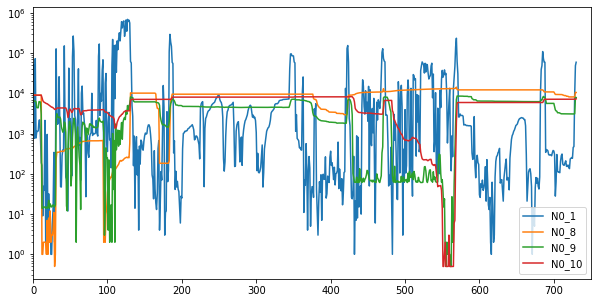

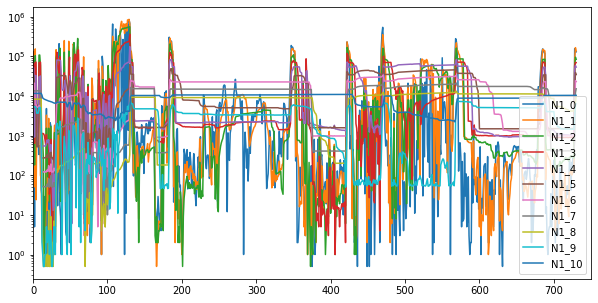

In [24]:
fig, axs = plt.subplots(figsize=(10, 3))
df['heap'].plot()
df['hugePages'].plot()
axs.legend()
axs.grid()
axs.set_xlim(0.,ymax)
plt.show()

fig, axs = plt.subplots(figsize=(10, 5))
buddy0 = df.filter(regex='N0_[189]')
buddy0.plot(ax=axs)
#axs.legend()
axs.set_xlim(0.,ymax)
plt.yscale("log")
plt.show()
fig, axs = plt.subplots(figsize=(10, 5))
buddy1 = df.filter(regex='N1_')
buddy1.plot(ax=axs)
#axs.legend()
axs.set_xlim(0.,ymax)
plt.yscale("log")
plt.show()

